In [3]:
# Imports

%matplotlib widget

import ipywidgets as widgets
import matplotlib.pyplot as plt
import math
import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift
import scipy.signal as sc
import scipy.io.wavfile as sc_wav
import csv 
import pandas as pd


In [4]:
def compararConTabla(pitch, pitchTable):
    encontrado = 0

    if pitch <= pitchTable[0]:
        pitchCorrecto = pitchTable[0]
        encontrado = 1

    if encontrado == 0:
        if pitch > pitchTable[len(pitchTable)-1]:
            pitchCorrecto = pitchTable[len(pitchTable)-1]
            encontrado = 1
        
    i = 1
    while encontrado == 0:
        if pitch > pitchTable[i] and pitch <= pitchTable[i+1]:
            pitchCorrecto = pitchTable[i+1]
            encontrado = 1
        i = i+1

    return pitchCorrecto

In [5]:
def auto_corr(x,fm):

    T = 1/fm 
    pmin = 50
    pmax = 400

    Tmin = 1/pmax
    Tmax = 1/pmin

    nmin = int(math.floor(Tmin/T))
    nmax = int(math.ceil(Tmax/T))

    x_cor = np.correlate(x,x,mode='full')
    x_cor = x_cor[len(x):len(x_cor)]

    i = np.argmax(x_cor[nmin:nmax])

    nF0 = i+nmin
    T0 = nF0*T

    F0 = 1/T0

    return F0

In [20]:
def estimarF0(signal, F0Ref):

    tvent = 0.032
    tstep = 0.005804988662131519

    tamanioVent = int(tvent*rate)
    nstep = int(tstep*rate)

    cantidadVentanasRef = len(F0Ref)
    #cantidadVentanasRef = int((len(signal)-tamanioVent-tamanioVent/2-nstep)/nstep)

    cantidadVentanasEstimacion = int((len(signal)/tamanioVent))
    vent = np.hamming(tamanioVent)

    ini = tamanioVent//2
    F0Estimada = np.zeros(cantidadVentanasRef)

    # print(cantidadVentanasRef)
    # print(len(F0Estimada))
    for i in range(cantidadVentanasRef):
        if F0Ref[i]>0:
            F0Estimada[i] = auto_corr(signal[ini:ini + tamanioVent]*vent,rate)
        ini = ini + nstep


    treshold = 200
    for i in range(cantidadVentanasRef):
        if F0Estimada[i]>=treshold:
            F0Estimada[i] = F0Estimada[i-1]
            #for i in range(cantidadVentanasRef-1):  
            # if  abs(F0Estimada[i+1]-F0Estimada[i]) or abs(F0Estimada[i-1]-F0Estimada[i]) >=treshold:    
            #        if F0Estimada[i-1]!=0 and F0Estimada[i+1]!=0:
            #            F0Estimada[i]=F0Estimada[i-1]/2 + F0Estimada[i+1]/2
            #        else:
            #            F0Estimada[i]=0
    return F0Estimada

In [24]:
rate, signal = sc_wav.read('dataset_proyecto/vocadito_1.wav')

ref_aux = pd.read_csv('dataset_proyecto/vocadito_1_f0.csv', names = ['f0','t'])

ref = []
for col in ref_aux:
    col_ref = ref_aux[col].tolist()
    ref.append(col_ref)

F0Ref = ref[1]
tRef = ref[0]

tvent = 0.032
tstep = 0.005804988662131519
tamanioVent = int(tvent*rate)
nstep = int(tstep*rate)
cantidadVentanasRef = len(F0Ref)
vent = np.hamming(tamanioVent)

#Estimacion de F0 usando autocorrelacion

F0Estimada = estimarF0(signal, F0Ref)

pitchTable=[0,16.352,17.324,18.354,19.445,20.602,21.827,23.125,24.500,25.957,27.500,29.135,
            30.868,32.703,34.648,36.708,38.891,41.203,43.654,46.249,48.999,51.913,55.000,58.270,
            61.735,65.406,69.296,73.416,77.782,82.407,87.307,92.499,97.999,103.830,110.000,
            116.540,123.470,130.800,138.590,146.830,155.560,164.810,174.610,185.000,196.000,
            207.650,220.000,233.080,246.940,261.630,277.180,293.660,311.130,329.630,349.230,
            369.990,392.000,415.300,440.000,466.160,493.880,523.250,554.370,587.330,622.250,
            659.260,698.460,739.990,783.990,830.610,880.000,932.330,987.770,1046.500,1108.700,
            1174.700,1244.500,1318.500,1396.900,1480.000,1568.000,1661.200,1760.000,1864.700,
            1975.500,2093.000,2217.500,2349.300,2489.000,2637.000,2793.800,2960.000,3136.000,
            3322.400,3520.000,3729.300,3951.100,4186.000,4434.900,4698.600,4978.000,5274.000,
            5587.700,5919.900,6271.900,6644.900,7040.000,7458.600,7902.100,8372.000,8869.800,
            9397.300,9956.100,10548.100,11175.300,11839.800,12543.900,13289.800,14080.000,
            14917.200,15804.300,16744.000,17739.700,18794.500,19912.100,21096.200,22350.600]

F0RefSegunTabla = np.zeros(len(F0Ref))

for i in range(len(F0Ref)-1):
    F0RefSegunTabla[i] = compararConTabla(F0Ref[i], pitchTable)

F0EstimadaSegunTabla = np.zeros(len(F0Estimada))
for i in range(len(F0Estimada)-1):
    F0EstimadaSegunTabla[i] = compararConTabla(F0Estimada[i], pitchTable)


Gráficos de F0 y la correspondiente F según las notas definidas en la tabla

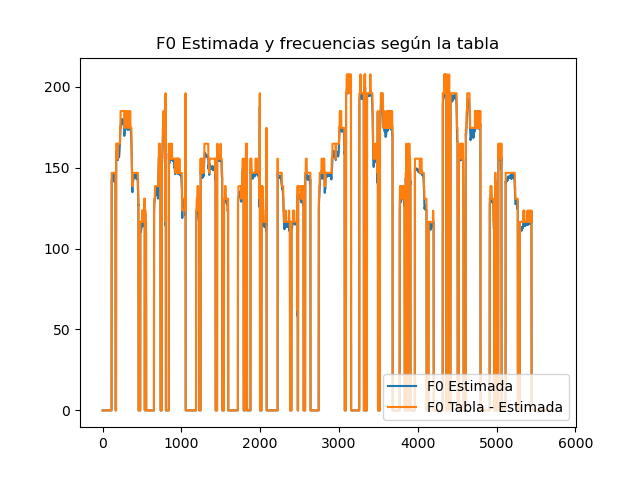

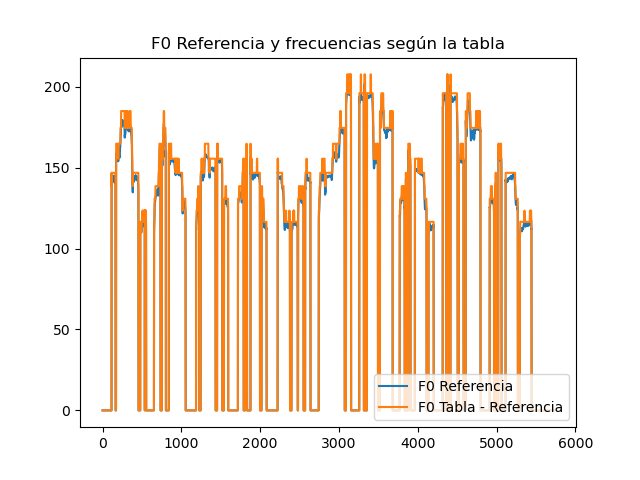

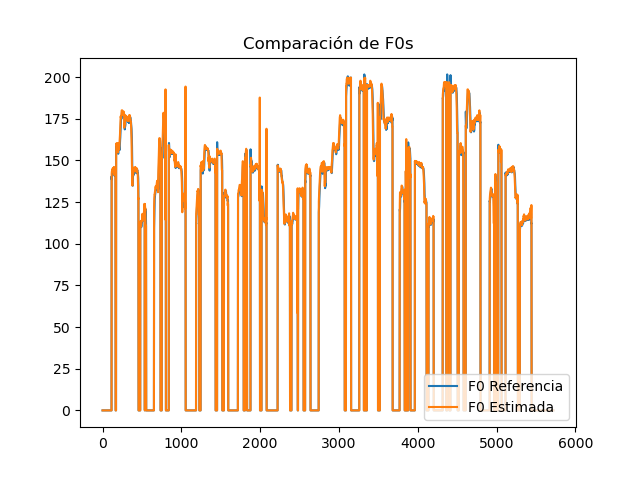

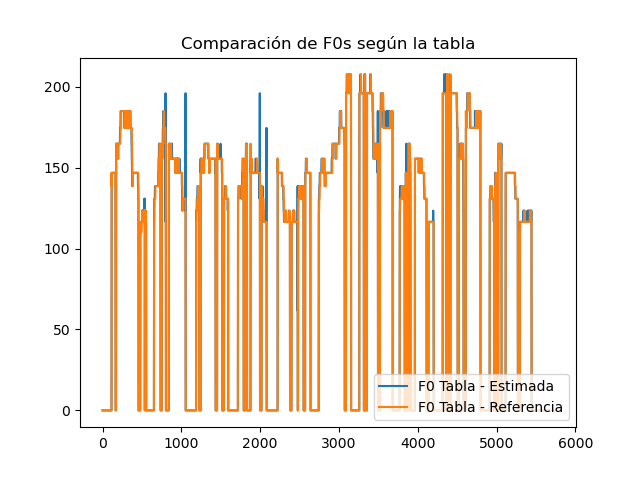

In [26]:
#GRAFICOS

#F0 estimada
fig, ax = plt.subplots()
ax.plot(F0Estimada, label = 'F0 Estimada')
ax.plot(F0EstimadaSegunTabla, label = 'F0 Tabla - Estimada')
legend = ax.legend(loc='lower right')
plt.title('F0 Estimada y frecuencias según la tabla')
plt.show()

#F0 referencia
fig, ax = plt.subplots()
ax.plot(F0Ref, label = 'F0 Referencia')
ax.plot(F0RefSegunTabla, label = 'F0 Tabla - Referencia')
legend = ax.legend(loc='lower right')
plt.title('F0 Referencia y frecuencias según la tabla')
plt.show()

#Comparación F0s
fig, ax = plt.subplots()
ax.plot(F0Ref, label = 'F0 Referencia')
ax.plot(F0Estimada, label = 'F0 Estimada')
legend = ax.legend(loc='lower right')
plt.title('Comparación de F0s')
plt.show()

#Comparación F0s según la tabla
fig, ax = plt.subplots()
ax.plot(F0EstimadaSegunTabla, label = 'F0 Tabla - Estimada')
ax.plot(F0RefSegunTabla, label = 'F0 Tabla - Referencia')
legend = ax.legend(loc='lower right')
plt.title('Comparación de F0s según la tabla')
plt.show()

<ipython-input-23-ea4ee3e8a735>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, abs(z), vmin = 0)


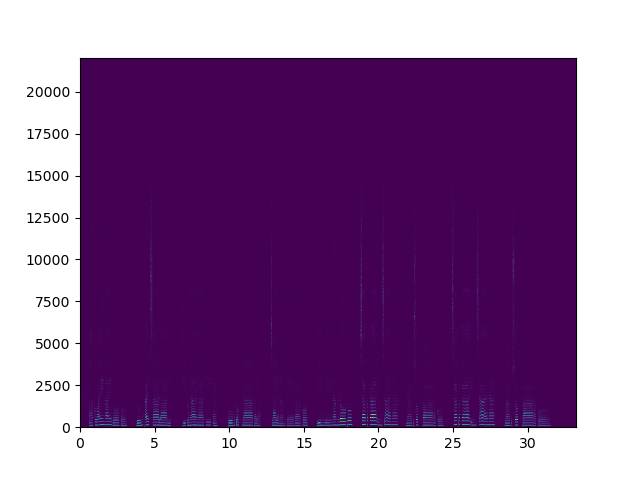

<ipython-input-23-ea4ee3e8a735>:9: RuntimeWarning: invalid value encountered in true_divide
  ratio = F0EstimadaSegunTabla/F0Estimada
<ipython-input-23-ea4ee3e8a735>:23: ComplexWarning: Casting complex values to real discards the imaginary part
  S_corrected[j,k] = z[y,k]


[1. 1. 1. ... 1. 1. 1.]


<ipython-input-23-ea4ee3e8a735>:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t,f,abs(S_corrected),vmin=0)


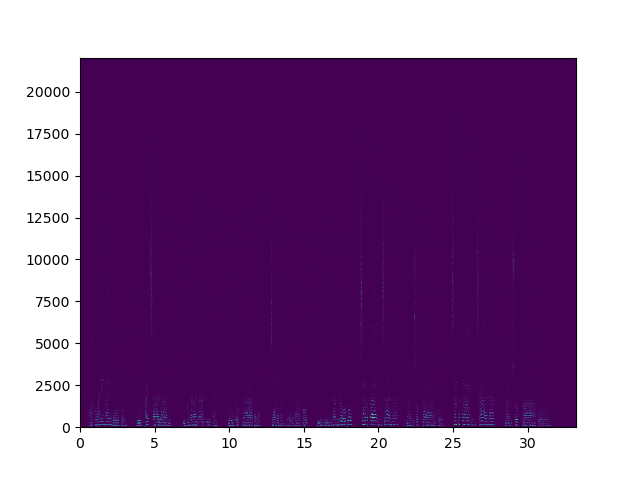

5722
5722


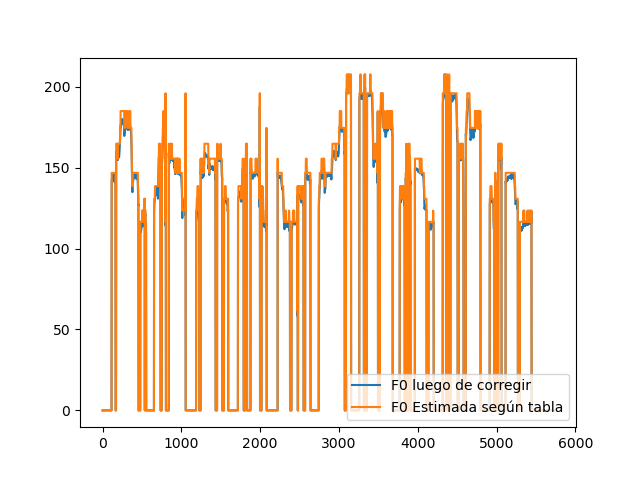

In [23]:
f, t, z = sc.stft(signal, rate, vent, nperseg = tamanioVent, noverlap = tamanioVent**0.75)

plt.figure()
plt.pcolormesh(t, f, abs(z), vmin = 0)
plt.show()

pcorr2 = F0Estimada

ratio = F0EstimadaSegunTabla/F0Estimada
ratio[np.isnan(ratio)] = 1
S_corrected = np.zeros((len(f),len(t)))
print(ratio)
for k in range(len(t)):
    for j in range(len(f)):
        y = round(j/ratio[k])
          
        #Prevents negative indices
        if y < 1:
            y = 1
          
        #Non-constant frequency scaling
        if y <= len(f):
            S_corrected[j,k] = z[y,k]
          
        
plt.figure()
plt.pcolormesh(t,f,abs(S_corrected),vmin=0)
plt.show()


t,senal = sc.istft(S_corrected, rate, vent, nperseg = tamanioVent, noverlap = tamanioVent**0.75)

ini = tamanioVent//2
pcorr2 = np.zeros(cantidadVentanasRef)
print(cantidadVentanasRef)
print(len(pcorr2))
for i in range(cantidadVentanasRef):
    if F0Ref[i]>0:
        pcorr2[i] = auto_corr(senal[ini:ini + tamanioVent]*vent,rate)
    
    ini = ini + nstep


treshold = 200
for i in range(cantidadVentanasRef):
    
   if pcorr2[i]>=treshold:
       pcorr2[i] = pcorr2[i-1]

fig, ax = plt.subplots()

ax.plot(F0Estimada, label = 'F0 luego de corregir')
ax.plot(F0EstimadaSegunTabla, label = 'F0 Estimada según tabla')
legend = ax.legend(loc='lower right')
plt.show()

sc_wav.write('test_01.wav',rate,senal.astype(np.int16))
sc_wav.write('test_02.wav',rate,signal.astype(np.int16))
rate2, senal2 = sc_wav.read('test_01.wav')


